In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('sales.csv')
df.head()

,Month,Sales
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [3]:
# check null value
df.isnull().sum()

Month    1
Sales    2
dtype: int64

In [4]:
df = df.dropna()

In [5]:
df.dtypes

Month     object
Sales    float64
dtype: object

In [6]:
# convert Month to Datatime
df['Month'] = pd.to_datetime(df['Month'])

In [7]:
# set Month as index
df.set_index('Month', inplace=True)
df.head()

,Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0


<AxesSubplot:xlabel='Month'>

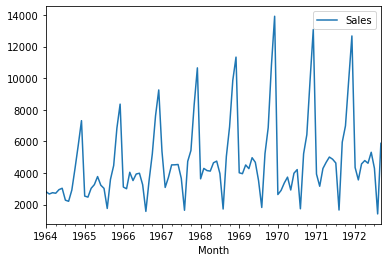

In [8]:
# visualize the data
df.plot()

### Check for Stationarity

In [9]:
from statsmodels.tsa.stattools import adfuller

In [10]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [11]:
adfuller_test(df['Sales'])

ADF Test Statistic : -1.8335930563276264
p-value : 0.36391577166024336
#Lags Used : 11
Number of Observations Used : 93
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


### Transforming to Stationary by Differencing

In [12]:
df['Seasonal First Difference']=df['Sales']-df['Sales'].shift(12)

In [13]:
# check stationarity for first order seasonal differencing
adfuller_test(df['Seasonal First Difference'].dropna())

ADF Test Statistic : -7.626619157213164
p-value : 2.060579696813685e-11
#Lags Used : 0
Number of Observations Used : 92
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


<AxesSubplot:xlabel='Month'>

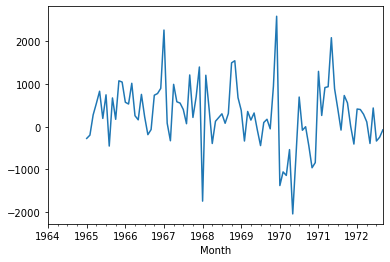

In [14]:
df['Seasonal First Difference'].plot()

### Autocorrelation and Partial Autocorrelation

In [18]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

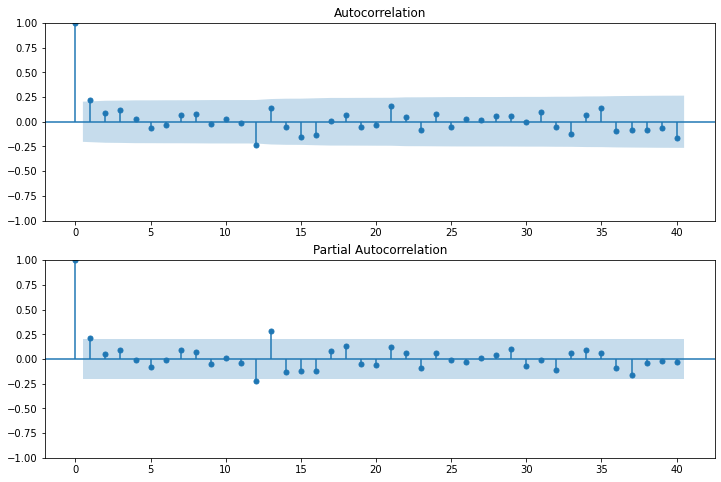

In [17]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['Seasonal First Difference'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df['Seasonal First Difference'].dropna(),lags=40,ax=ax2)

### SARIMA Model

In [28]:
# split training and testing data
# using the last 12 months for testing
df_train = df[:-12]
df_test = df[-12:]

In [31]:
model=sm.tsa.statespace.SARIMAX(df_train['Sales'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

/Users/shuqianliu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/shuqianliu/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.01406D+00    |proj g|=  8.92552D-02

At iterate    5    f=  6.96821D+00    |proj g|=  2.06543D-02

At iterate   10    f=  6.96191D+00    |proj g|=  1.88011D-03

At iterate   15    f=  6.96186D+00    |proj g|=  3.15906D-04

At iterate   20    f=  6.96180D+00    |proj g|=  7.71999D-03

At iterate   25    f=  6.95707D+00    |proj g|=  3.78431D-02

At iterate   30    f=  6.94323D+00    |proj g|=  2.55808D-02

At iterate   35    f=  6.94256D+00    |proj g|=  5.94615D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

<AxesSubplot:xlabel='Month'>

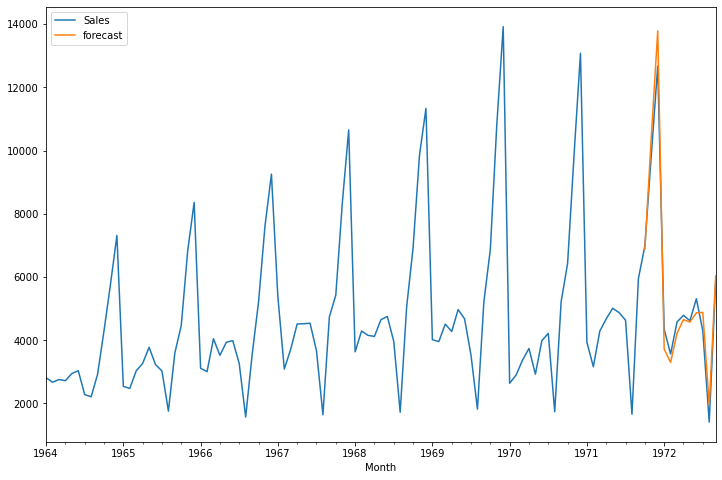

In [32]:
df['forecast']=results.predict(start=len(df_train), end=len(df)-1, dynamic=True)
df[['Sales','forecast']].plot(figsize=(12,8))